In [52]:
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow import keras 
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


from keras.applications import VGG16, VGG19
from keras.applications import ResNet50, ResNet50V2, ResNet152V2
from keras.applications import InceptionV3, Xception

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [53]:
DATASET = '/Users/DELL/Desktop/dataset1'

LABELS = os.listdir('/Users/DELL/Desktop/dataset1')
print(LABELS)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


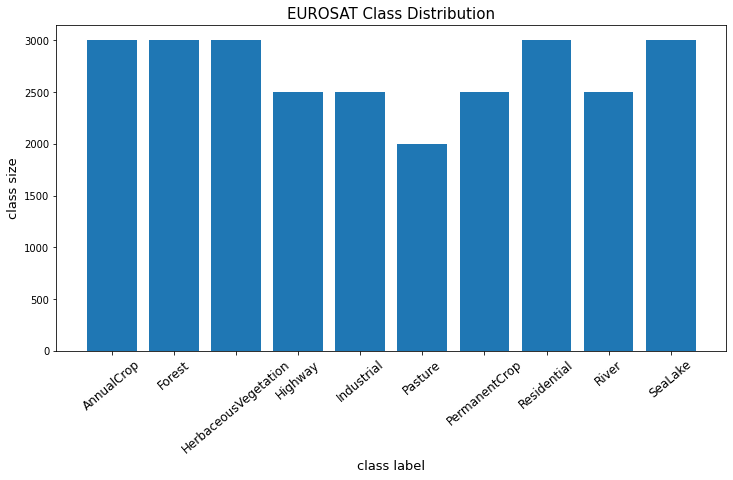

In [54]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

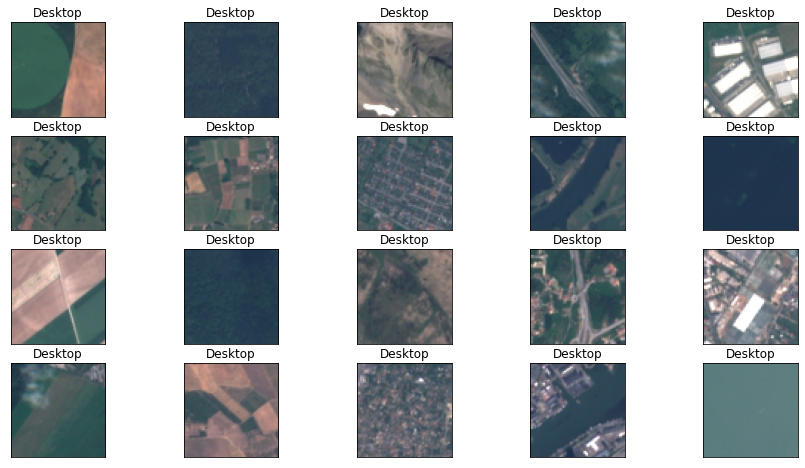

In [55]:
img_paths = [os.path.join(DATASET, l, l+'_10.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_20.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

In [56]:


train = '/Users/DELL/Desktop/dataset1/train'
test = '/Users/DELL/Desktop/dataset1/test'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (train, test):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(train, l)):
        os.mkdir(os.path.join(train, l))

    if not os.path.exists(os.path.join(test, l)):
        os.mkdir(os.path.join(test, l))

In [57]:
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('/Users/DELL/Desktop/dataset1','/Users/DELL/Desktop/dataset1/train', i) for i in train_paths]
    new_test_paths = [re.sub('/Users/DELL/Desktop/dataset1','/Users/DELL/Desktop/dataset1/test', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('/Users/DELL/Desktop/dataset1/train/', '/Users/DELL/Desktop/dataset1/test/', i[1])):
                shutil.copy(i[0], i[1])
    
#     print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('train', 'test', i[1])):
                shutil.copy(i[0], i[1])

  0%|▏                                                                             | 43/21600 [00:00<00:50, 427.20it/s]

moving training files..


100%|█████████████████████████████████████████████████████████████████████████████| 5400/5400 [00:12<00:00, 416.22it/s]


In [58]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=train,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=test,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [59]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [60]:
np.save('class_indices', train_generator.class_indices)

In [61]:
# Using image data generator api in keras for making image dataset 
rf_gen = ImageDataGenerator(rescale=1./255)

rf_train_generator = rf_gen.flow_from_directory(
    directory=train,
    target_size=(64, 64),
    # by using batch_size as training data size we can extract data from this iterator
    batch_size=21600, 
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

rf_test_generator = rf_gen.flow_from_directory(
    directory=test,
    target_size=(64, 64),
    batch_size=5400,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [62]:
train = rf_train_generator.next()
X_train = train[0].reshape(21600, 12288)
y_train = train[1]

test = rf_test_generator.next()
X_test = test[0].reshape(5400, 12288)
y_test = test[1]

In [63]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

In [64]:
# Note that for different CNN models we are using different setup of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
       
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
    
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

In [65]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/Users/DELL/Downloadsvgg16_weights_tf_dim_ordering_tf_kernels.h5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [66]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
vgg16_model.summary()

C:\Users\DELL\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [67]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/Users/DELL/Downloads/vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [68]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=10,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

<ipython-input-68-28b6288db749>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg16_history = vgg16_model.fit_generator(train_generator,


Epoch 1/10
337/337 [==============================] - ETA: 0s - loss: 1.7318 - categorical_accuracy: 0.5449
Epoch 1: val_categorical_accuracy improved from -inf to 0.70219, saving model to /Users/DELL/Downloads\vgg16_weights_tf_dim_ordering_tf_kernels.h5
337/337 [==============================] - 537s 2s/step - loss: 1.7318 - categorical_accuracy: 0.5449 - val_loss: 0.8586 - val_categorical_accuracy: 0.7022
Epoch 2/10
337/337 [==============================] - ETA: 0s - loss: 1.0590 - categorical_accuracy: 0.6311
Epoch 2: val_categorical_accuracy improved from 0.70219 to 0.74554, saving model to /Users/DELL/Downloads\vgg16_weights_tf_dim_ordering_tf_kernels.h5
337/337 [==============================] - 556s 2s/step - loss: 1.0590 - categorical_accuracy: 0.6311 - val_loss: 0.7669 - val_categorical_accuracy: 0.7455
Epoch 3/10
337/337 [==============================] - ETA: 0s - loss: 1.0128 - categorical_accuracy: 0.6480
Epoch 3: val_categorical_accuracy did not improve from 0.74554
337/

In [69]:
# re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

vgg16_model.load_weights('/Users/DELL/Downloads/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

train_generator.reset()
test_generator.reset()
    
vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=10,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/10


<ipython-input-69-91165945f8e7>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg16_history = vgg16_model.fit_generator(train_generator,


337/337 [==============================] - ETA: 0s - loss: 1.2268 - categorical_accuracy: 0.5779
Epoch 1: val_categorical_accuracy improved from 0.77400 to 0.83147, saving model to /Users/DELL/Downloads\vgg16_weights_tf_dim_ordering_tf_kernels.h5
337/337 [==============================] - 1810s 5s/step - loss: 1.2268 - categorical_accuracy: 0.5779 - val_loss: 0.5612 - val_categorical_accuracy: 0.8315 - lr: 1.0000e-04
Epoch 2/10
337/337 [==============================] - ETA: 0s - loss: 0.7549 - categorical_accuracy: 0.7572
Epoch 2: val_categorical_accuracy improved from 0.83147 to 0.86477, saving model to /Users/DELL/Downloads\vgg16_weights_tf_dim_ordering_tf_kernels.h5
337/337 [==============================] - 1799s 5s/step - loss: 0.7549 - categorical_accuracy: 0.7572 - val_loss: 0.4877 - val_categorical_accuracy: 0.8648 - lr: 1.0000e-04
Epoch 3/10
337/337 [==============================] - ETA: 0s - loss: 0.5562 - categorical_accuracy: 0.8388
Epoch 3: val_categorical_accuracy impro

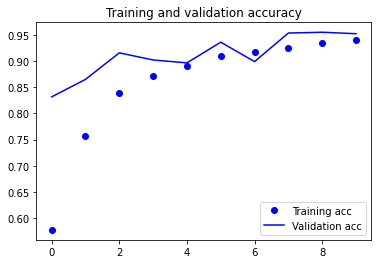

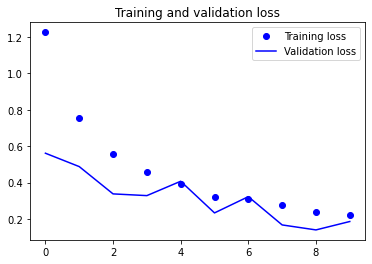

In [70]:
#plot_history(vgg16_history)
acc = vgg16_history.history['categorical_accuracy']
val_acc = vgg16_history.history['val_categorical_accuracy']
loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [71]:
vgg16_model.load_weights('/Users/DELL/Downloads/vgg16_weights_tf_dim_ordering_tf_kernels.h5')


class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory='/Users/DELL/Desktop/dataset1/test',
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.


<ipython-input-71-f0084afc5cd8>:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = vgg16_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))


Accuracy: 0.9518518518518518
Global F2 Score: 0.9518518518518517


,Precision,Recall,F-Score,Support
AnnualCrop,0.889600,0.926667,0.907755,600.0
Forest,0.949126,0.995000,0.971522,600.0
HerbaceousVegetation,0.963702,0.885000,0.922676,600.0
Highway,0.933981,0.962000,0.947783,500.0
Industrial,0.995825,0.954000,0.974464,500.0
Pasture,0.971649,0.942500,0.956853,400.0
PermanentCrop,0.878788,0.928000,0.902724,500.0
Residential,0.998311,0.985000,0.991611,600.0
River,0.956262,0.962000,0.959123,500.0
SeaLake,0.991525,0.975000,0.983193,600.0


In [72]:
vgg16_model.save('/Users/DELL/Downloads/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

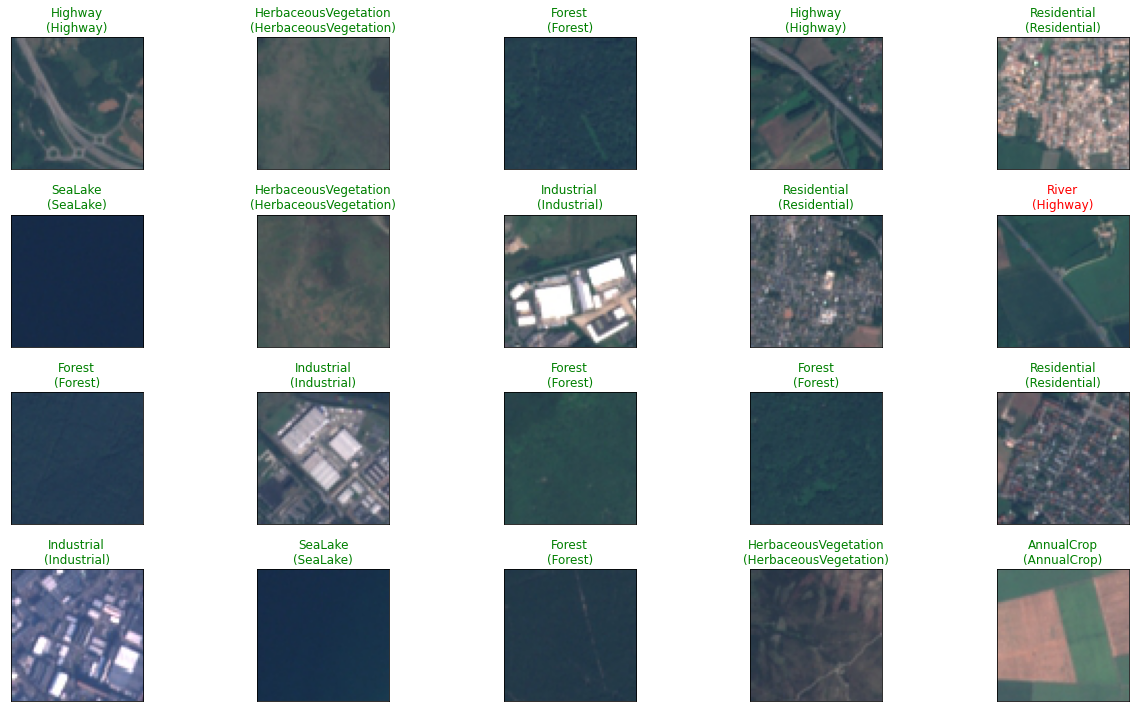

In [73]:
plot_predictions(true_classes, predictions, test_generator_new, class_indices)